# Import the Libraries

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy import integrate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from scipy.optimize import differential_evolution
from scipy.optimize import minimize, NonlinearConstraint
import json
from scipy.stats import norm
from scipy.integrate import solve_ivp
from scipy import integrate
import warnings
import time

In [2]:

import numpy as np
import scipy
import sklearn
import sys 
import json
import warnings
import time

print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)
print("scikit-learn version:", sklearn.__version__)
print("JSON module: built-in")
print("Warnings module: built-in")




Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]
NumPy version: 2.2.6
SciPy version: 1.15.2
scikit-learn version: 1.7.2
JSON module: built-in
Warnings module: built-in


# Call the Custom Functions:
 - SMB function
 - Optimization function

The funcitons are written in separatep python scripts and need to be called from these locations. Lucky for us, we can us the "from" function in python to call an external script then specify which models (functions) we
want to "import" from the external script for our use. 

The optimization function is called "constrained_MOBO_func" and is sorted in the SMB_OPT script, while the SMB funciton is called "SMB" in the SMB_func_general script

In [3]:
from SMB_OPT import constrained_MOBO_func 
from SMB_func_general import SMB
from ploting_json_optimization_results import plot_raff_ext_pareto

Hello from SMB_OPT.py





### 📌 Assigning Variables to the SMB Functions
Before executing the SMB simulation or optimization routines, all input variables must be clearly defined. In Simulated Moving Bed (SMB) chromatography, inputs fall into three primary categories:

1. **System (Physical) Specifications** – e.g., column diameter and configuration  
2. **Thermodynamic Variables** – equilibrium and adsorption characteristics e.g., Henry's constant  
3. **Operating Variables** – e.g., flow rates and indexing parameters

Defining these correctly ensures the model accurately represents the physical system and can be used reliably for simulation and optimization.

---

### 1. System Specifications

Key decisions in this category include:

- **i. Number of columns per zone**: Define the number of columns in each zone (Z1, Z2, Z3, Z4).
- **ii. Column characteristics**: Since all columns are assumed to be identical, these specifications apply to all columns across the system.
- **iii. Column arrangement**: Determine the configuration of input and output nodes for each column, including any subzoning considerations.



**i. Number of columns per zone**

Specify how many columns belong to each of the four SMB zones (e.g.,Z1, Z2, Z3, Z4). 

- Z1 = the number of columns between the DESORBENT and the EXTRACT
- Z2 = the number of columns between the EXTRACT and the FEED
- Z3 = the number of columns between the FEED and the RAFFINATE
- Z4 = the number of columns between the RAFFINATE and the DESORBENT

For the "2:2:2:2" configuration:

Z1 = 2

Z2 = 2

Z3 = 2

Z4 = 2

In python, we can wirte more succinclty in 1 line rather than 4 lines: 

Z1,  Z2,  Z3,  Z4 = 2, 2, 2, 2

This would look like this:

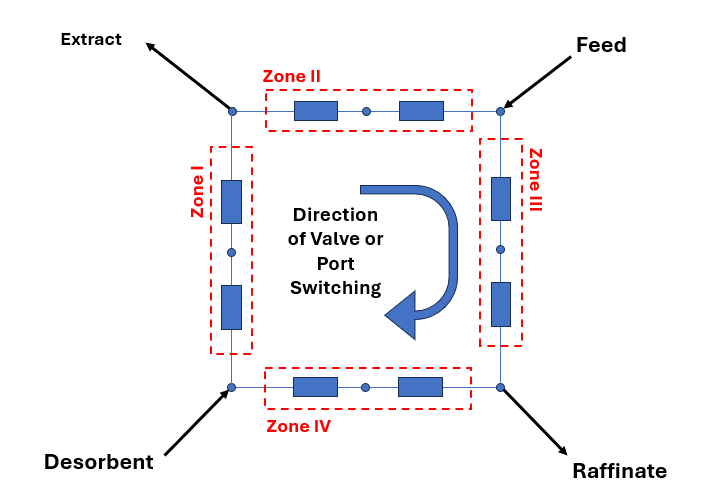


We can also use an "open" view:

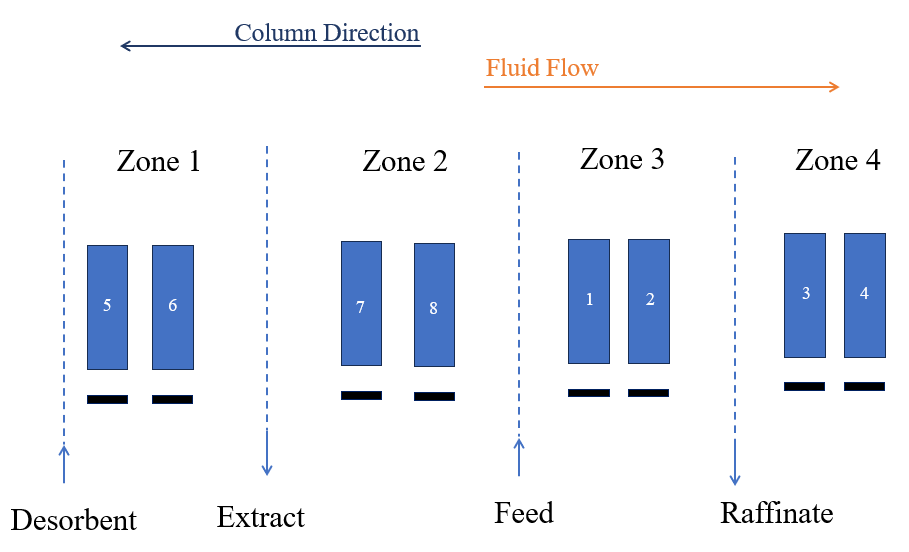



In [4]:
Z1, Z2, Z3, Z4 = 3,3,3,3 # *3 for smb config
zone_config = np.array([Z1, Z2, Z3, Z4])

 **ii. Column Characteristics**

In [5]:
L = 30 # cm, Length of one column
d_col = 2.6 # cm, Column internal diameter
e = 0.56   # -,  bed voidage

# Calculate the:
# Radius,
r_col = d_col / 2 # cm
# Area,
A_col = np.pi * (r_col ** 2) # cm^2
# Volume,
V_col = A_col*L # cm^3
# ---------------------------------------------------------
# Assuming the pipe diameter is 20% of the column diameter:
d_in = 1 # cm

**iii. Column Arrangement**

Typically, each column feeds its proceeding column in the column train, this can be depicted below for the 1:1:1:1 configuration. In the SMB model, the feed is always placed in-btween zones 2 and 3. 

In the configuration below, vertical dotted lines represent the demarckations between zones also showing where the Feed, Raffinate, Extract or Desorbent ports are located. The "Bays" act as position 

labels of the system. For instance, the columns are initally located at the bays with the same number-labels i.e. in the figure below, column 1 at Bay 1,  col 2 at Bay 2 and so on. Additionally, please note that columns are counted from the feed onwards.


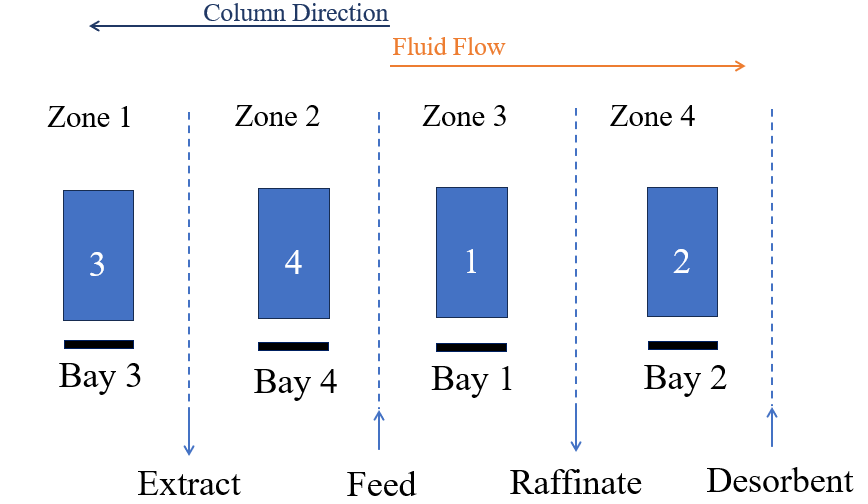


After the first indexing period, the columns shift to the left resulting in the figure below.

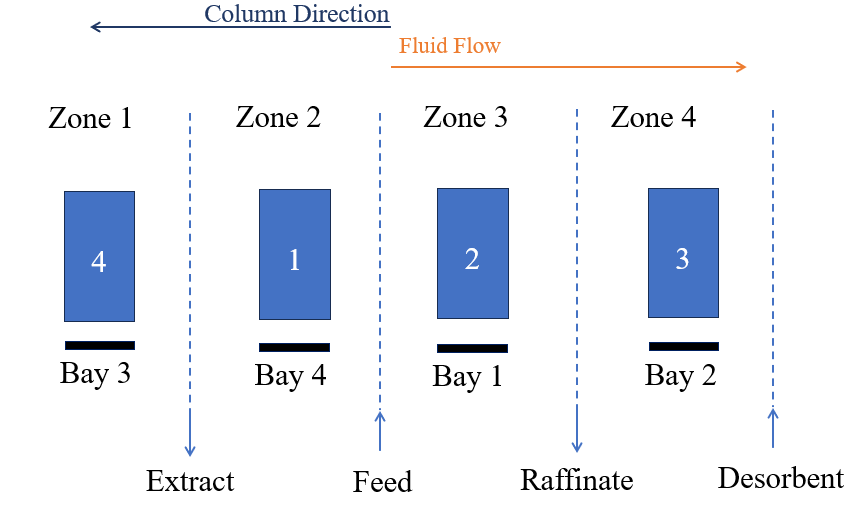


Notice the columns moved but the bays didint! This is useful because now we can track the movement of any (and all) columns by just knowing the starting Bay. Fruther to this, in the university 

operation certain columns can be grouped. "Grouping" is simply a term that can be usde to remember how to allocate the effluent from one column-Bay to feed the next. In the conventional SMB operation

there is no grouping and each column is fed the effluent from the preceeding Bay: Bay 1 feeds Bay 2, Bay 2 feeds Bay 3 and so on. This is depicted in  below for the slightly larger 24 column configuration, 3:3:3:3.

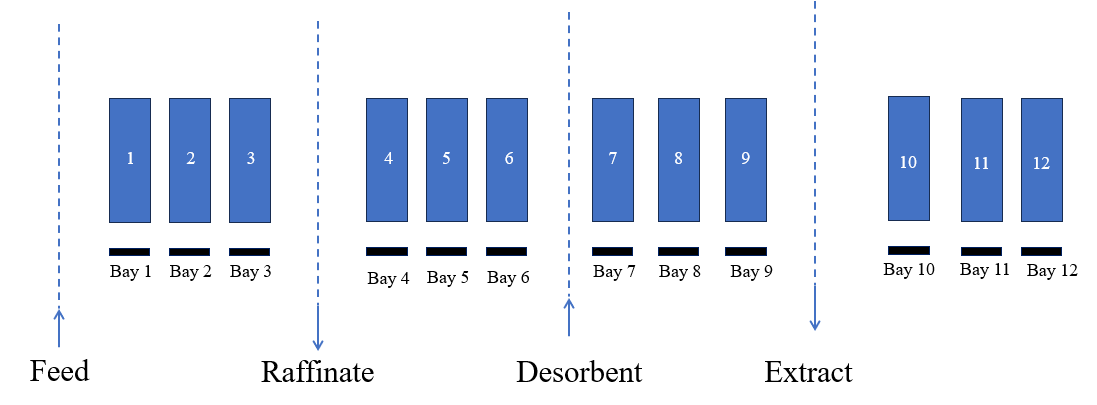

Now consider the case were we group columns 11 and 12. This means that they will share the effluent from column 10. Column 10s effluent is spilit and fed to both col 11 and col 12. Subsequently, the efflucent from col 11 and 12 is mixed and fed to col 1 (after adding the feed). This shown below.
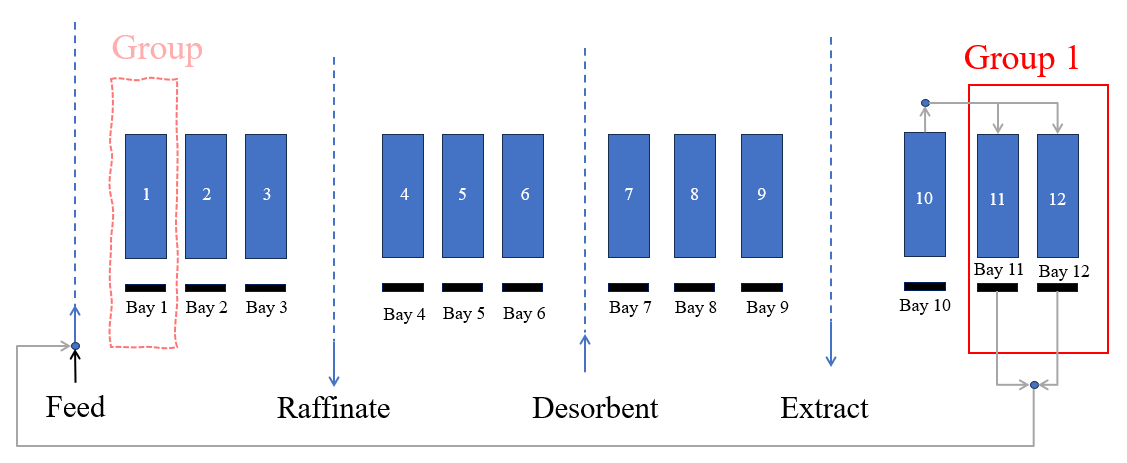

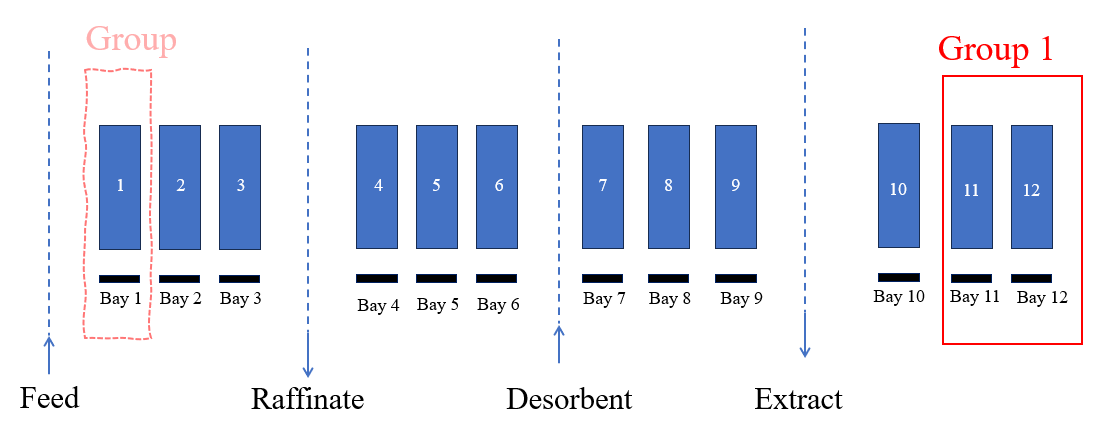

For short we can simply add the box without drawing the lines:

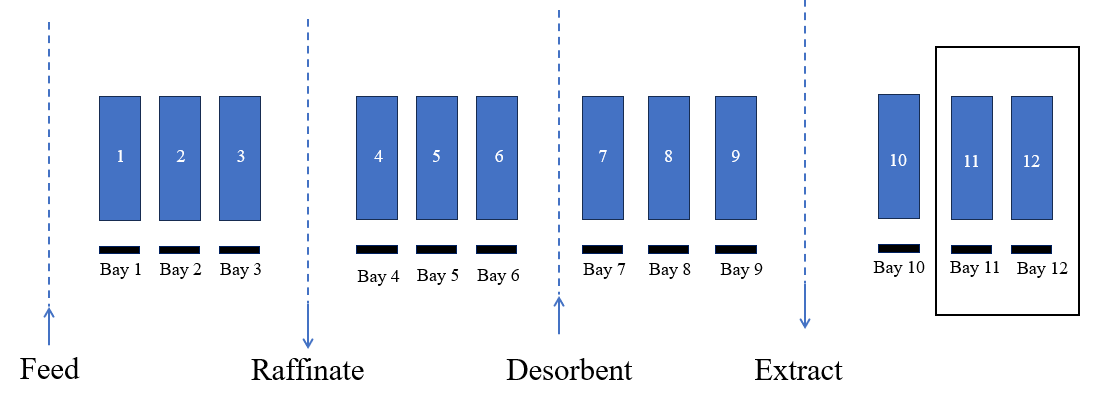

# Setting the Grouping Arrangement in the SMB model

Next, we see how the grouping arrangment can be translated to the model. 

The grouping style is incorperated in the "grouping_type" parameter. In this parameter, we list all the, n,  groups:

grouping_type = [grp_1, grp_2, grp_3, .........., grp_n] ---> where grp = group

grp_j = [[feed_bays], [receiving_bays]]

Where:
- grp_j is the jth group counted from the feed in the direction of the liquid flow.

- feed_bays: the bay(s) that feed the set of receiving bays in "receiving_bays"

- receiving_bays: the set of bays that receive material from the feed bay(s)

From the above example, the group formed by bays' 11 & 12 recieved the split effluent from bay 10, giving: grp1 = [[10], [11, 12]] "bay 10 feeds bays 11 and 12". We use the bays and not the 

columns themselves because the bays remain fixed throughout the operation; which ever column occupies the given bay folllows the "rule" in grp.


Notice also that we also need to incorperate the columns that are affected by the introduction of the group for instance, in the previous example, the column in bay 1 received the combined 

effuent from the group formed by bays' 11 & 12. In that case, we'd need to specify: grp2 = [[11, 12], [1]]. Therefore, to fully define the grouping from our 3:3:3:3 example write:


grp1 = [ [ 10 ] , [ 11, 12 ] ]

grp2 = [ [ 11, 12 ] , [ 1 ] ] 

grouping_type = [grp1, grp2] 




## Grouping Examples

#### 1. (12 col, 3:3:3:3) - Example configuration

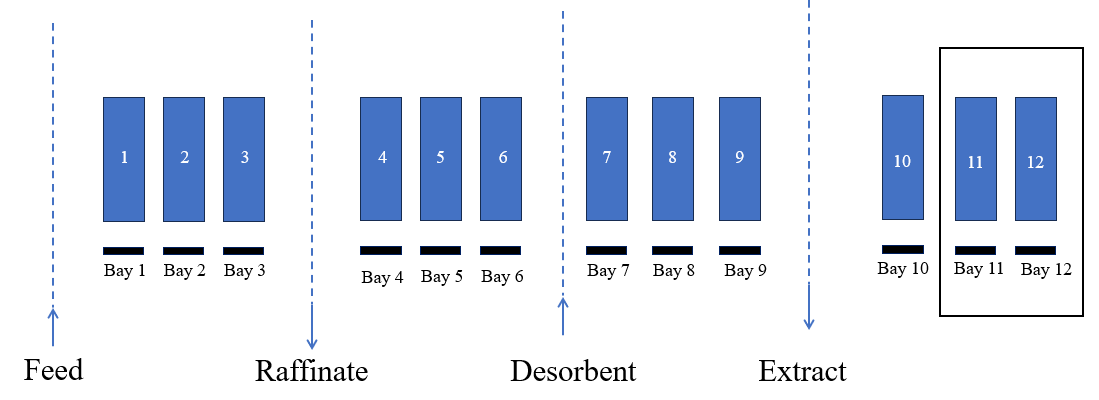



In [6]:
grp1 = [ [ 10 ] , [ 11, 12 ] ]

grp2 = [ [ 11, 12 ] , [ 1 ] ] 

grouping_type_example = [grp1, grp2] 

#### 2. (24 col, 3:9:3:9) Config for Glucose Fructose Commissioning 


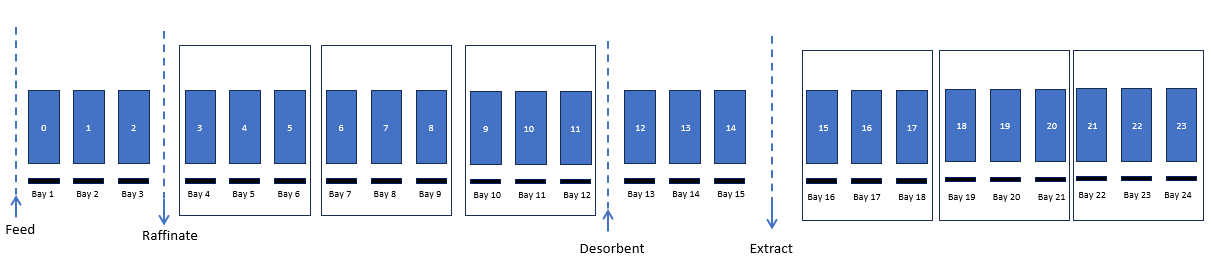

In [7]:
# 2. 24 col Config for Glucose Fructose Commissioning 
grp_1 = [[3], [4,5,6]] # ---> in group 1, there are 2 columns stationed at bay 3 and 4. Bay 3 and 4 recieve feed from bay 1"""
grp_2 = [[4,5,6], [7,8,9]] 

grp_3 = [[7,8,9], [10,11,12]] 
grp_4 = [[10,11,12], [13]]

grp_5 = [[15],[16, 17, 18]]
grp_6 = [[16, 17, 18],[19, 20, 21]]
grp_7 = [[19, 20, 21], [22, 23, 24]]
grp_8 = [[22, 23, 24], [1]]

# PACK:
grouping_type_GF_commissiong = [grp_1, grp_2, grp_3, grp_4, grp_5, grp_6, grp_7, grp_8]


#### 2. (24 col, 6:6:6:6) Config for Borate-HCl

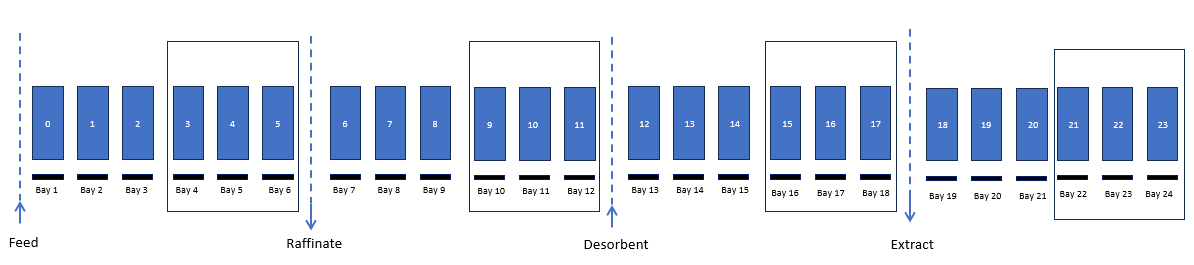

In [8]:
# 3.  24 col Config for Borate HCl
grp_1 = [[22, 23, 24], [1]] # ---> in subzone 1, there are 2 columns stationed at bay 3 and 4. Bay 3 and 4 recieve feed from bay 1"""

grp_2 = [[3], [4,5,6]] 
grp_3 = [[4,5,6], [7]] 

grp_4 = [[9], [10, 11, 12]] 
grp_5 = [[10,11,12], [13]]

grp_6 = [[15],[16, 17, 18]]
grp_7 = [[16, 17, 18],[19]]

grp_8 = [[21],[22, 23, 24]]

# # PACK:
grouping_type_BH_illovo = [grp_1, grp_2, grp_3, grp_4, grp_5, grp_6, grp_7, grp_8]


#### Set the Grouping

In [9]:

# Default - No Subzoning (can apply to any number of columns)
default_grouping = []

grouping_type = default_grouping # = no_subzoning

#### Species' Thermodynamic Parameters

All the thermodynamic parameters are stored in the species dictionary: 'species_dict' . Please pay close attention to units.

            Parameter                       Units
            -----------------------------------------------------------
            (All) Liquid concentraions      | (g/cm³)
            Henry's constant, H             | N/A
            Mass Transfer coefficient, kav  | (1/s)
            Dispersion coefficient, Da      | (cm²/s)

- You would have measured the feed concentrations for each sepcied prior th running the SMB - this information is stored in C_feed in (g/cm³)

- Kinetic parameters such as H, kav and Da would have been determined from regression onto column test data.

In [10]:
species_dict = {

        "Glucose": {
            "color": "red",                 # Plot color
            "C_feed": 0.0430,               # Feed concentration (g/cm³)

            "H": 0.27,                       # Henry's constant
            "kav": 0.031,                   # Mass Transfer coefficient (1/s)
            "Da": 6.41e-7,                  # Dispersion coefficient (cm²/s)
            "purity_constraint": 99.5 # %   # Minimum Acceptable Purity to be used in optimization


        },

        "Fructose": {
            "color": "green",
            "C_feed": 0.0430 * 0.75,
            
            "H": 0.53,
            "kav": 0.0218,
            "Da": 6.41e-7,           
            "purity_constraint": 99.5 # %   # Minimum Acceptable Purity to be used in optimization
        }
}


# No need to change below this line
# Extract species names
Names = list(species_dict.keys())

purity_constraints = [species_dict[names]["purity_constraint"]/100 for names in Names] # and constraint in dictionary

num_comp = len(Names)       # Number of components

iso_type = 'CUP'            # UNC or CUP

# Extract plot colors
color = [species_dict[name]["color"] for name in Names]

# Extract feed concentrations
parameter_sets = [{"C_feed": species_dict[name]["C_feed"]} for name in Names]


# Extract Henry's constants into a NumPy array
cusotom_isotherm_params_all = np.array([[species_dict[name]["H"]] for name in Names])

# Extract kav parameters
kav_params_all = [[species_dict[name]["kav"]] for name in Names]

# Extract axial dispersion coefficients
Da_all = np.array([species_dict[name]["Da"] for name in Names])








#### Operating Parameters

The parameter "n_num_cycles" defines the number of complete switching cycles the SMB system will execute during the simulation. 

Each cycle represents a full rotation of the inlet and outlet ports. For example, Setting n_num_cycles = 2 means the simulation will run through two full cycles. 

Alternatively you may want to specify the number of hours of operation rather than the nunmber of cycles; the parameter "t_simulation_end" specifies the total simulation time in hours. 

"None" is loosely equivalent to "Nothing"

If set to "t_simulation_end = None", the simulation duration will be automatically determined based on the number of cycles. Conversly, if "n_num_cycles = None" the simulation duration 

will be determined based on the t_simulation_end. 

Note:
- As a heuristic, Cyclic Steady State (CSS) is typucally reached after 8-10 cycles. This can varry from system to system



In [11]:
n_num_cycles = 1  # Number of Cycles you want the SMB to run for 
t_simulation_end = None # HRS

#### Other Simulation Parameters

The SMB model uses finite differencing to solve transport equations in each column. 

The parameter nx_per_col sets the number of spatial nodes per column. 

Higher values improve resolution but significantly increase computation time. 

Based on prior testing, nx_per_col = 15 offers a good balance between accuracy and speed


In [12]:
nx_per_col = 15 # Number of spatial discretizations per column

### Assigning Optimization Variables


##### ⚙️ Optimization Parameter Overview

This section defines the configuration for optimizing SMB performance, targeting either purity, recovery, or a weighted combination.

- **Objective Direction**  
  `job_max_or_min = 'maximize'`  
  Specifies whether to maximize or minimize the objective function for this context set to 'maximize'.

- **Reference Time**  
  `t_reff = 20` (minutes)  
  Used to normalize switching time.

- **Flowrate Constraints**  
  `Q_max = 12`, `Q_min = 1` (L/h)  
  Sets bounds on allowable external flowrates during optimization. This is based on the mechanical limits of the pumps on the pilot plant - check the pump curves.

- **Optimization Budgets**  
 `optimization_budget = 2`  
  Controls the number of initial samples and total optimization iterations.

- **Purity Constraints**  
  `constraint_threshold = [0.995, 0.995]`  
  Minimum required purity levels (e.g., 99.5%).

- **Objective Weighting**  
  `PF_weight = 10`  
  Emphasizes purity in the objective function. Higher values prioritize purity over recovery.

- **Variance Scaling**  
  `x_i = 0.01`  
  Scales the variance term in the objective function to penalize instability.

- **Optimization Bounds**  
  `bounds = [...]`  
  Specifies search intervals for decision variables:  
  - `m1`, `m2`, `m3`, `m4`: Mass transfer coefficients  
  - `t_index/t_reff`: Normalized switching time





In [13]:
# Do you want to maximize or minimize the objective function?
job_max_or_min = 'maximize' # 'maximize' or 'minimize'

# - - - - -
t_reff = 10 # min # Maximum Indexing Time
# - - - - -
similarity_threshold = 0.005 # 0.5% # Threshold for considering candidates as similar
# checks if proposed candidates are within 1% of any of the previous candidates when roounded to 3 decimal places
# If so, a new candidate is randomly generated to prevent the search from getting stuck.

# - - - - -
Q_max = 1 # L/h # Constraints on the external flowrates
Q_min = 0.1 # L/h
# - - - - -
optimization_budget = 2
# - - - - -
PF_weight = 10 # Weighting factor for purity in the objective function | 1, 5, 10, 20
# - - - - -
x_i = 0.01 # power to which the variance is multiplied | 1, 2, 5, 10, 100
# - - - - -



##### Guidance for Setting bounds and the Initial Guess

Decision variables are the 4 flowrate ratios and the indexing time: [m_1, m_2, m_3, m_4, t_index]. The flowrate ratios are directly related to the internal flowrates.

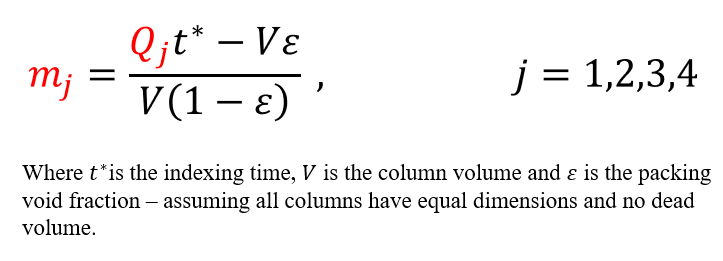



In turn, the internal flowrates are related to the external flowrates.

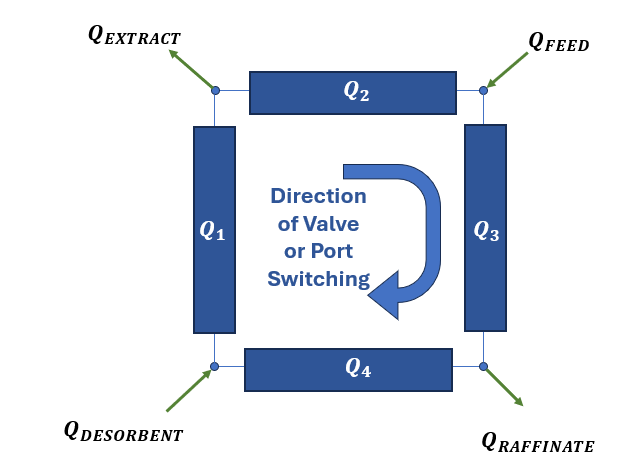

##### The following are heuristics you can emply when setting the bounds relative to the estimated physical parameters
- From triangle theory, better separation occurs when when m_2 and m_3 are similar. Therefore, both m_2 and m_3 were each set to be bounded over the same range. This range is set to be slightly beyond H_fructose and beneath H_glucose.


- Further,  m_1 and m_4 are set to be bounded well-beyond and beneath H_fructose = 0.53 and H_glucose = 0.27 respectively. 

- Irrespective of the indexing time, any sensible operation conditions are likely to follow this pattern. The indexing time
acts more as a sizing parameter..

- When bounding the indexing time, keep in mind that smaller indexing times result in larger internal flowrates. For pilot plant operation 5-20min is a good range while 30s to 10 min can be used for bench scale.



In [14]:

bounds = [  

(0.5, 1),    # m1       (High Range)

(0.1, 0.55), # m2       (Middle Range)
(0.1, 0.55), # m3       (Middle Range)

(0.1, 0.40), # m4       (Low Range)
    
(0.1, 1),    # t_index  (normalized)
]

2.2 Initial Guess

2.2.1. First Define functions that convert the flowrate ratios to internal flowrates and vise versa

In [15]:
def mj_to_Qj(mj, t_index_min):
    '''
    Converts flowrate ratios to internal flowrates - flowrates within columns
    '''
    Qj = (mj*V_col*(1-e) + V_col*e)/(t_index_min*60) # cm^3/s
    return Qj

def Qj_to_mj(Qj, t_index_min):
    '''
    Converts flowrate ratios to internal flowrates - flowrates within columns
    '''
    mj = (Qj * t_index_min*60 - V_col*e)/(V_col*(1-e)) # cm^3/s
    return mj


2.2.2. Set the initial Guess

In [16]:
t_index_min = 10 # min (will be optimized)
triangle_guess=  np.array([0.508, 0.297, 0.413, 0.162, t_index_min])

In [17]:
# Calcualte the internal flowrates

m1, m2, m3, m4 = triangle_guess[0],triangle_guess[1],triangle_guess[2],triangle_guess[3]
Q_I, Q_II, Q_III, Q_IV = mj_to_Qj(m1, t_index_min), mj_to_Qj(m2, t_index_min), mj_to_Qj(m3, t_index_min), mj_to_Qj(m4, t_index_min) # (L/h) Internal flowrates
Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])

# File Storage Parameters

In [18]:
# When saving the json:
Description = [f"Description: Optimizting the Glu-Fru system for the sythetic solution on PCR.Ca. {optimization_budget+1} iterations. {zone_config} configuration. We placed a upper flowrate constraint of {Q_min}<Q<{Q_max} L/h"]
save_name_inputs = f"Inputs_Glu_Fru_commision_opt_{optimization_budget+1}iter.json" 
save_name_outputs = f"Outputs_Glu_Fru_commision_opt_{optimization_budget+1}iter.json"


#### Pack all Input Parameters

In [19]:
# 1. Optimization input parameters
opt_inputs = [Description, save_name_inputs, save_name_outputs, job_max_or_min, t_reff, Q_max, Q_min, optimization_budget, purity_constraints, PF_weight, bounds, triangle_guess, x_i, similarity_threshold]
# 2. SMB input parameters
SMB_inputs = [iso_type, Names, color, num_comp, nx_per_col, e, Da_all, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets, cusotom_isotherm_params_all, kav_params_all, grouping_type, t_simulation_end]
# Pack:
# -------------------------------
batch = [opt_inputs, SMB_inputs]

# Run the Optimization

MOBO Optimization

In [44]:
results = constrained_MOBO_func(batch, SMB)



 OPTIMIZATION INPUTS SUMMARY: 

Column Volume: 159.27874753700252 cm^3 | 0.15927874753700252 L
Column CSA: 5.3092915845667505 cm^2
Column Length: 30 cm

Configuration: [3 3 3 3], No grouping
Column Diameter: 2.6 cm
Optimization Budget: 2
pF_weight: 10
exploration (xi): 0.01
thresholds: [0.995, 0.995]
[Q_max, Q_min] = [1.0, 0.1] L/h
bounds:
m1: (0.5, 1)
m2: (0.1, 0.55)
m3: (0.1, 0.55)
m4: (0.1, 0.4)
t_index: (1.0, 10) min


----------------------------------
Trangle Guess Reuslts
----------------------------------
Inputs:
----------------------------------
Q_internal: [0.74878851 0.66006387 0.7088414  0.60329693] L/h [Q1, Q2, Q3, Q4]
Q_external: [0.04877752 0.10554447 0.14549158 0.08872463] L/h [QF, QR, QD, QE]
----------------------------------
Ouputs:
Recoveries [Raff, Ext]: [[0.00672073 0.00652599]], 
Purities [Raff, Ext]: [[0.97723022 0.97206492]]
----------------------

Generated Initial Samples in 0.08872033754984537 min
----------------------


 Iteration 1
--------------------

## Plot Optimization Results

starting to unpack
done loading
shape m1: (21,)


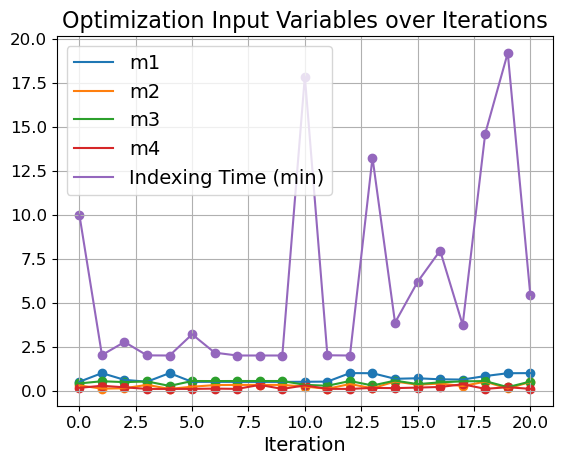

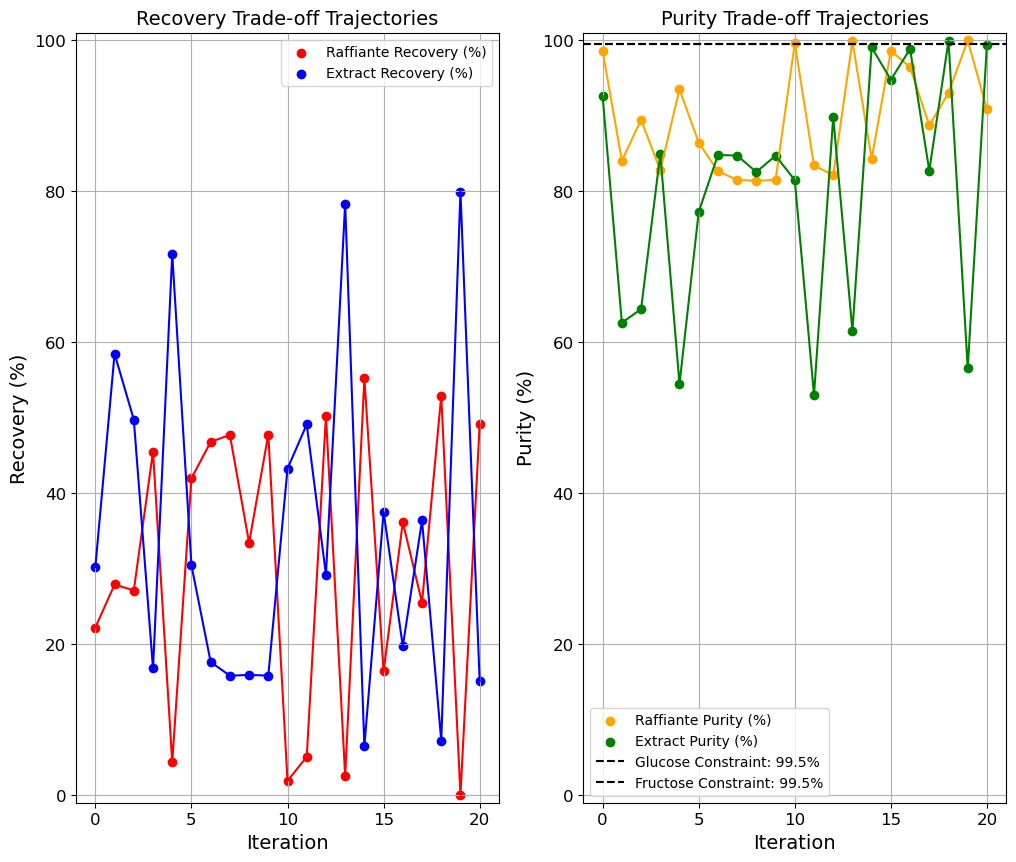

c:\Users\nawau\OneDrive\Desktop\smb_optimization_files\ploting_json_optimization_results.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()


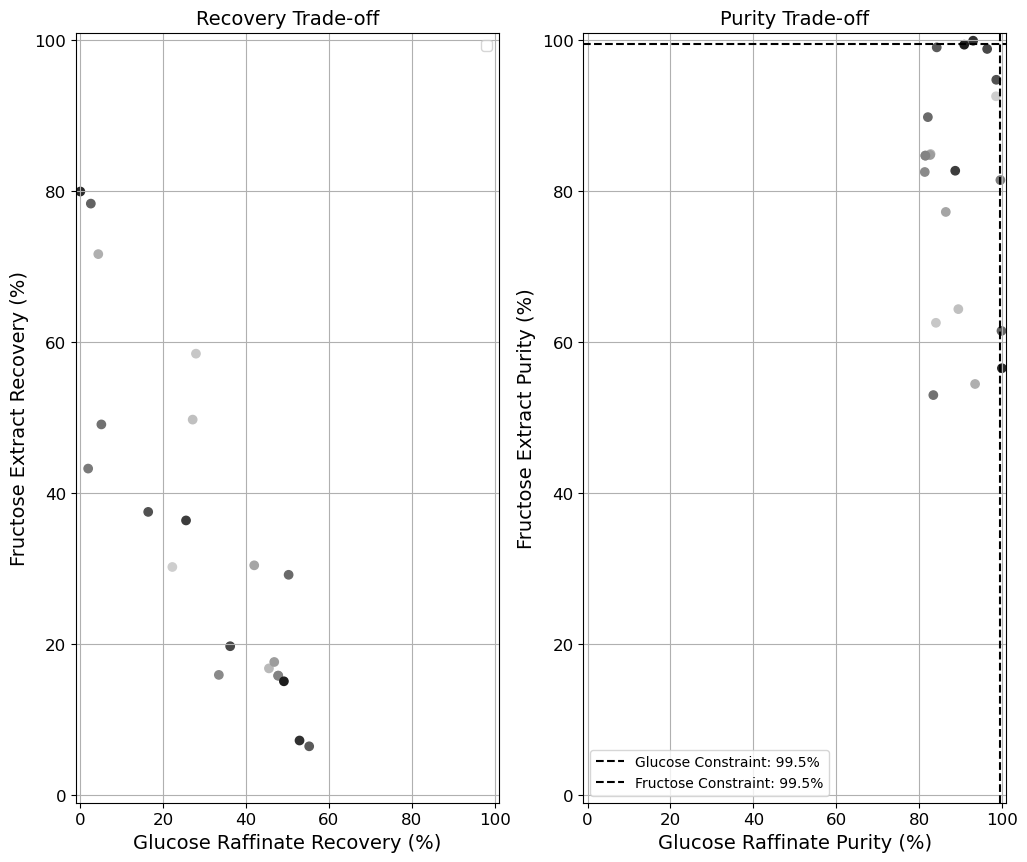


===== Pareto Front Summary =====
Glucose Pareto-optimal points: 7
Fructose Pareto-optimal points: 9
Dual-optimal points (both fronts): 5

Feasible points (Purity ≥ 99.5%): 0



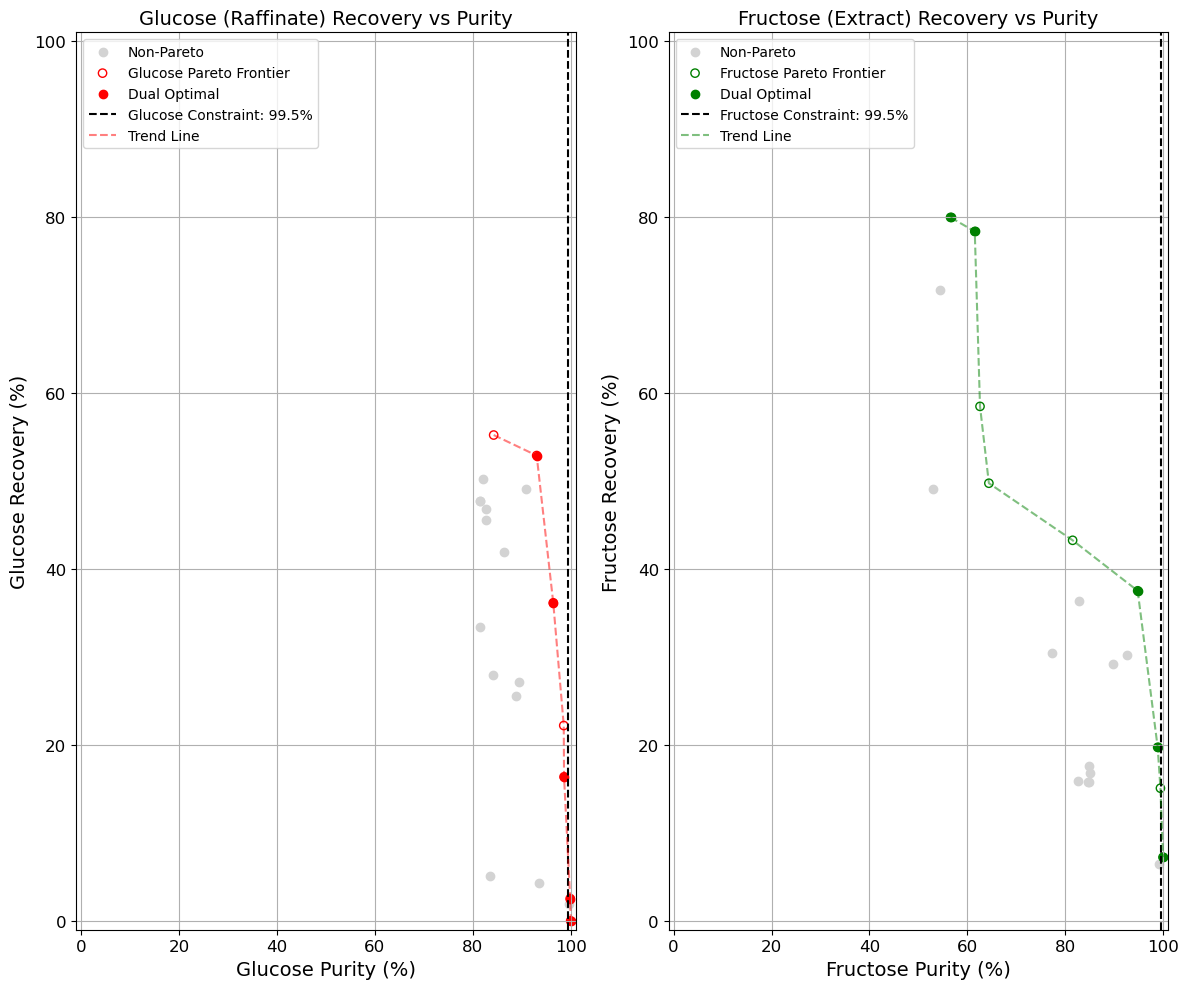

In [20]:
outputs_path = "Outputs_Glu_Fru_commision_opt_21iter_20251105_133426.json"
inputs_path = "Inputs_Glu_Fru_commision_opt_21iter_20251105_133426.json"

plot_raff_ext_pareto(inputs_path, outputs_path, Names, purity_constraints)
